In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gprofiler import GProfiler
import os

# Create output directory
os.makedirs('results/enrichment', exist_ok=True)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [6]:
# Load all DE results
de_results = pd.read_csv('results/tables/deseq2_all_results.csv')

print(f"Total genes in DE results: {len(de_results)}")
print(f"Columns: {list(de_results.columns)}")
de_results.head()

Total genes in DE results: 134
Columns: ['gene_id', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']


,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000160183,653.230814,1.259437,0.101287,12.434325,1.701716e-35,2.280299e-33
1,ENSG00000157557,7055.646667,0.671330,0.059320,11.317058,1.080366e-29,7.238454e-28
2,ENSG00000142156,167.954874,1.759491,0.180686,9.737860,2.078859e-22,9.285569e-21
3,ENSG00000154640,2208.654278,0.467644,0.057148,8.183105,2.766222e-16,7.413476e-15
4,ENSG00000182240,19952.661620,0.440655,0.053760,8.196753,2.469678e-16,7.413476e-15


In [7]:
# Significance thresholds
PADJ_THRESHOLD = 0.05
LOG2FC_THRESHOLD = 1  # |log2FC| > 1 means >2-fold change

# Filter for significant genes
sig_genes = de_results[
    (de_results['padj'] < PADJ_THRESHOLD) &
    (de_results['log2FoldChange'].abs() > LOG2FC_THRESHOLD)
].copy()

# Separate upregulated and downregulated genes
up_genes = sig_genes[sig_genes['log2FoldChange'] > 0]['gene_id'].tolist()
down_genes = sig_genes[sig_genes['log2FoldChange'] < 0]['gene_id'].tolist()
all_sig_genes = sig_genes['gene_id'].tolist()

print(f"Significant genes (padj < {PADJ_THRESHOLD}, |log2FC| > {LOG2FC_THRESHOLD}):")
print(f"  Total: {len(all_sig_genes)}")
print(f"  Upregulated in KO: {len(up_genes)}")
print(f"  Downregulated in KO: {len(down_genes)}")

Significant genes (padj < 0.05, |log2FC| > 1):
  Total: 6
  Upregulated in KO: 5
  Downregulated in KO: 1


In [8]:
# Initialize g:Profiler
gp = GProfiler(return_dataframe=True)

def run_enrichment(gene_list, name, sources=['GO:BP', 'GO:MF', 'GO:CC']):
    """
    Run g:Profiler enrichment analysis on a gene list.

    Parameters:
    - gene_list: list of gene IDs
    - name: description for logging
    - sources: databases to query (GO:BP, GO:MF, GO:CC, KEGG, REAC, etc.)

    Returns:
    - DataFrame with enrichment results
    """
    if len(gene_list) == 0:
        print(f"Warning: {name} gene list is empty!")
        return pd.DataFrame()

    print(f"\nRunning enrichment for {name} ({len(gene_list)} genes)...")

    results = gp.profile(
        organism='hsapiens',
        query=gene_list,
        sources=sources,
        user_threshold=0.05,  # Significance threshold
        significance_threshold_method='fdr',  # Multiple testing correction
        no_evidences=False
    )

    if len(results) > 0:
        print(f"  Found {len(results)} significant terms")
    else:
        print(f"  No significant terms found")

    return results

In [9]:
# Run GO enrichment analysis
go_all = run_enrichment(all_sig_genes, "All significant genes", sources=['GO:BP', 'GO:MF', 'GO:CC'])
go_up = run_enrichment(up_genes, "Upregulated genes", sources=['GO:BP', 'GO:MF', 'GO:CC'])
go_down = run_enrichment(down_genes, "Downregulated genes", sources=['GO:BP', 'GO:MF', 'GO:CC'])


Running enrichment for All significant genes (6 genes)...
  Found 3 significant terms

Running enrichment for Upregulated genes (5 genes)...
  Found 3 significant terms

Running enrichment for Downregulated genes (1 genes)...
  Found 28 significant terms


In [10]:
# View columns in results
if len(go_all) > 0:
    print("Columns in enrichment results:")
    print(go_all.columns.tolist())
    print("\nTop 10 GO terms for all significant genes:")
    display(go_all[['source', 'native', 'name', 'p_value', 'intersection_size']].head(10))

Columns in enrichment results:
['source', 'native', 'name', 'p_value', 'significant', 'description', 'term_size', 'query_size', 'intersection_size', 'effective_domain_size', 'precision', 'recall', 'query', 'parents', 'intersections', 'evidences']

Top 10 GO terms for all significant genes:


,source,native,name,p_value,intersection_size
0,GO:CC,GO:0005589,collagen type VI trimer,0.021937,1
1,GO:CC,GO:0098647,collagen beaded filament,0.021937,1
2,GO:CC,GO:0140086,basement membrane/interstitial matrix interface,0.021937,1


In [11]:
# Run KEGG pathway enrichment
kegg_all = run_enrichment(all_sig_genes, "All significant genes (KEGG)", sources=['KEGG'])
kegg_up = run_enrichment(up_genes, "Upregulated genes (KEGG)", sources=['KEGG'])
kegg_down = run_enrichment(down_genes, "Downregulated genes (KEGG)", sources=['KEGG'])


Running enrichment for All significant genes (KEGG) (6 genes)...
  Found 2 significant terms

Running enrichment for Upregulated genes (KEGG) (5 genes)...
  Found 2 significant terms

Running enrichment for Downregulated genes (KEGG) (1 genes)...
  No significant terms found


In [12]:
# Display KEGG results
if len(kegg_all) > 0:
    print("Top KEGG pathways for all significant genes:")
    display(kegg_all[['native', 'name', 'p_value', 'intersection_size']].head(10))
else:
    print("No significant KEGG pathways found for all genes")

Top KEGG pathways for all significant genes:


,native,name,p_value,intersection_size
0,KEGG:03265,Virion - Ebolavirus and Lyssavirus,0.029685,1
1,KEGG:05165,Human papillomavirus infection,0.030863,2


In [13]:
def plot_enrichment_bar(results, title, top_n=15, figsize=(10, 8)):
    """
    Create a bar plot of top enriched terms.
    """
    if len(results) == 0:
        print(f"No results to plot for: {title}")
        return None

    # Get top N results
    plot_data = results.head(top_n).copy()
    plot_data = plot_data.sort_values('p_value', ascending=True)

    # Create -log10(p-value) for better visualization
    plot_data['-log10(p)'] = -np.log10(plot_data['p_value'])

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Color by source (GO:BP, GO:MF, GO:CC, KEGG)
    colors = {'GO:BP': '#1f77b4', 'GO:MF': '#ff7f0e', 'GO:CC': '#2ca02c', 'KEGG': '#d62728'}
    bar_colors = [colors.get(s, '#7f7f7f') for s in plot_data['source']]

    # Create horizontal bar plot
    bars = ax.barh(range(len(plot_data)), plot_data['-log10(p)'], color=bar_colors)

    # Customize plot
    ax.set_yticks(range(len(plot_data)))
    ax.set_yticklabels(plot_data['name'], fontsize=9)
    ax.set_xlabel('-log10(p-value)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Add gene count labels
    for i, (bar, count) in enumerate(zip(bars, plot_data['intersection_size'])):
        ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                f'n={count}', va='center', fontsize=8)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=c, label=s) for s, c in colors.items() if s in plot_data['source'].values]
    if legend_elements:
        ax.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    return fig


def plot_enrichment_dot(results, title, top_n=15, figsize=(10, 8)):
    """
    Create a dot plot of top enriched terms (similar to clusterProfiler style).
    """
    if len(results) == 0:
        print(f"No results to plot for: {title}")
        return None

    plot_data = results.head(top_n).copy()

    # Calculate gene ratio
    plot_data['GeneRatio'] = plot_data['intersection_size'] / plot_data['query_size']
    plot_data['-log10(p)'] = -np.log10(plot_data['p_value'])

    fig, ax = plt.subplots(figsize=figsize)

    scatter = ax.scatter(
        plot_data['GeneRatio'],
        range(len(plot_data)),
        s=plot_data['intersection_size'] * 10,  # Size by gene count
        c=plot_data['-log10(p)'],  # Color by significance
        cmap='viridis',
        alpha=0.7,
        edgecolors='black',
        linewidths=0.5
    )

    ax.set_yticks(range(len(plot_data)))
    ax.set_yticklabels(plot_data['name'], fontsize=9)
    ax.set_xlabel('Gene Ratio', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, label='-log10(p-value)')

    # Add size legend
    sizes = [5, 10, 20]
    for size in sizes:
        ax.scatter([], [], s=size*10, c='gray', alpha=0.7, label=f'{size} genes')
    ax.legend(loc='lower right', title='Gene Count')

    plt.tight_layout()
    return fig

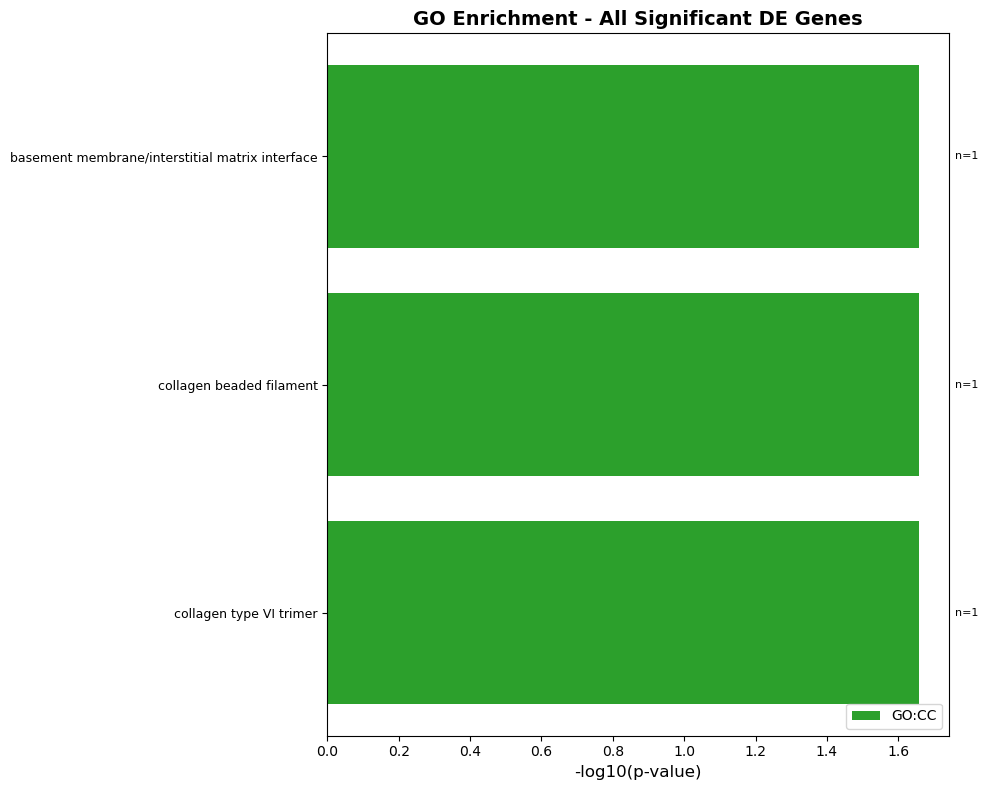

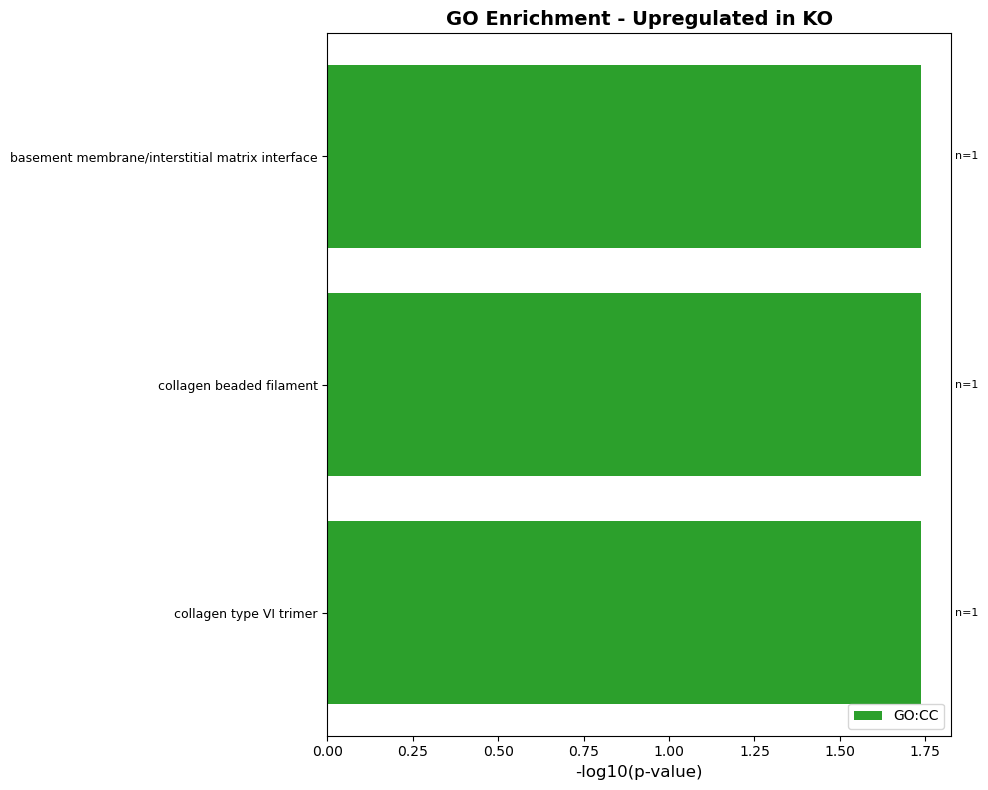

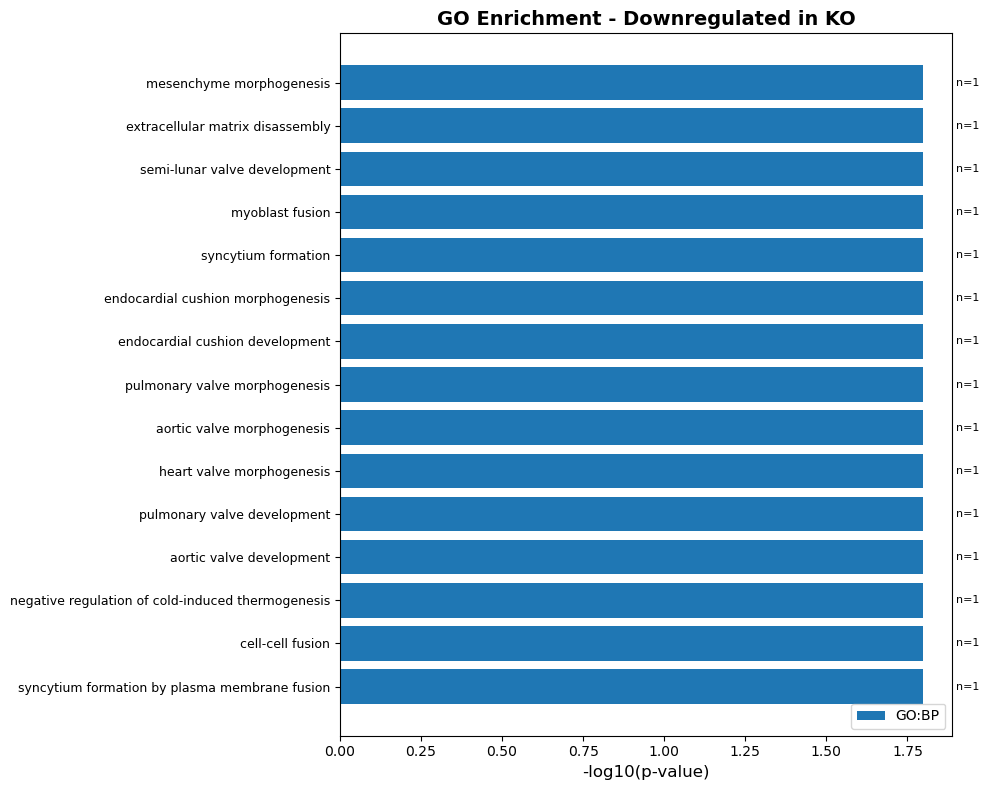

In [14]:
# Plot GO enrichment - All significant genes
fig = plot_enrichment_bar(go_all, 'GO Enrichment - All Significant DE Genes')
if fig:
    fig.savefig('results/enrichment/go_all_genes_bar.png', dpi=150, bbox_inches='tight')
    plt.show()
    
# Plot GO enrichment - Upregulated genes
fig = plot_enrichment_bar(go_up, 'GO Enrichment - Upregulated in KO')
if fig:
    fig.savefig('results/enrichment/go_upregulated_bar.png', dpi=150, bbox_inches='tight')
    plt.show()
# Plot GO enrichment - Downregulated genes
fig = plot_enrichment_bar(go_down, 'GO Enrichment - Downregulated in KO')
if fig:
    fig.savefig('results/enrichment/go_downregulated_bar.png', dpi=150, bbox_inches='tight')
    plt.show()

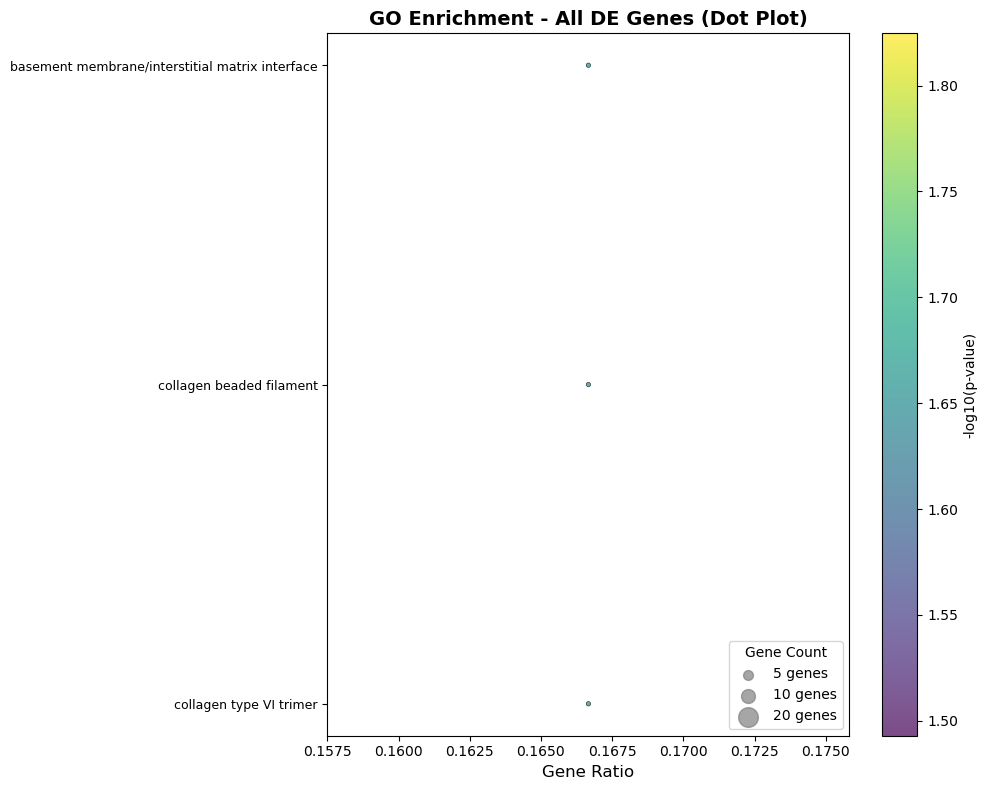

In [15]:
# Create dot plots (publication-style)
fig = plot_enrichment_dot(go_all, 'GO Enrichment - All DE Genes (Dot Plot)')
if fig:
    fig.savefig('results/enrichment/go_all_genes_dot.png', dpi=150, bbox_inches='tight')
    plt.show()

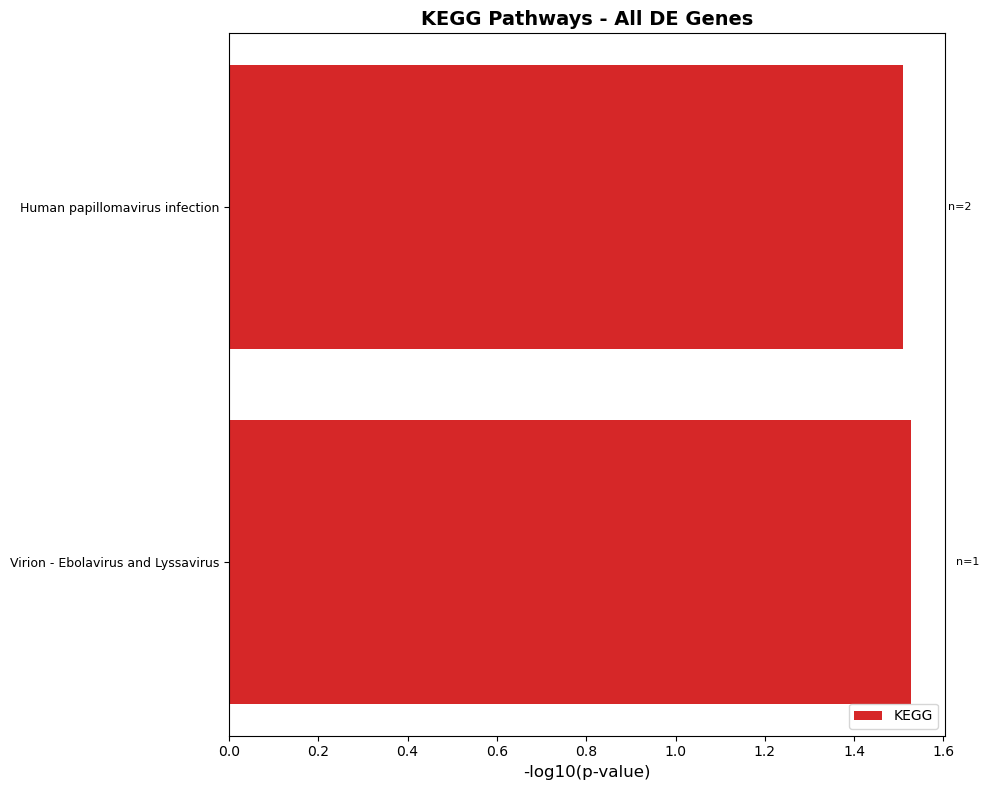

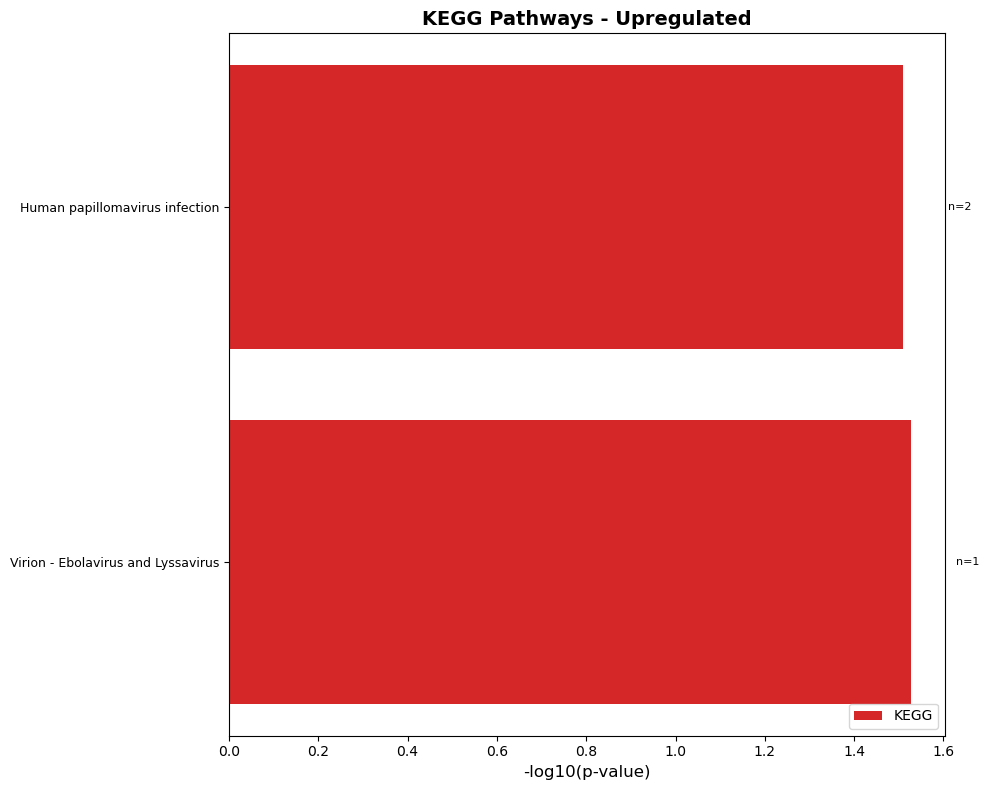

No results to plot for: KEGG Pathways - Downregulated


In [16]:
# Plot KEGG pathways for all gene sets
for results, name, filename in [
    (kegg_all, 'KEGG Pathways - All DE Genes', 'kegg_all'),
    (kegg_up, 'KEGG Pathways - Upregulated', 'kegg_up'),
    (kegg_down, 'KEGG Pathways - Downregulated', 'kegg_down')
]:
    fig = plot_enrichment_bar(results, name, top_n=10)
    if fig:
        fig.savefig(f'results/enrichment/{filename}_bar.png', dpi=150, bbox_inches='tight')
        plt.show()

In [17]:
def save_enrichment_results(results, filename):
    """Save enrichment results to TSV file."""
    if len(results) == 0:
        print(f"No results to save for {filename}")
        return

    # Select and rename columns for clarity
    cols_to_save = ['source', 'native', 'name', 'p_value', 'significant',
                    'term_size', 'query_size', 'intersection_size', 'intersections']

    # Only include columns that exist
    cols_to_save = [c for c in cols_to_save if c in results.columns]

    output = results[cols_to_save].copy()
    output.to_csv(f'results/enrichment/{filename}.tsv', sep='\t', index=False)
    print(f"Saved: results/enrichment/{filename}.tsv ({len(output)} terms)")

# Save GO results
save_enrichment_results(go_all, 'go_all_significant_genes')
save_enrichment_results(go_up, 'go_upregulated_genes')
save_enrichment_results(go_down, 'go_downregulated_genes')

# Save KEGG results
save_enrichment_results(kegg_all, 'kegg_all_significant_genes')
save_enrichment_results(kegg_up, 'kegg_upregulated_genes')
save_enrichment_results(kegg_down, 'kegg_downregulated_genes')

print("\nAll results saved to results/enrichment/")

Saved: results/enrichment/go_all_significant_genes.tsv (3 terms)
Saved: results/enrichment/go_upregulated_genes.tsv (3 terms)
Saved: results/enrichment/go_downregulated_genes.tsv (28 terms)
Saved: results/enrichment/kegg_all_significant_genes.tsv (2 terms)
Saved: results/enrichment/kegg_upregulated_genes.tsv (2 terms)
No results to save for kegg_downregulated_genes

All results saved to results/enrichment/


In [18]:
# Create a summary of enrichment analysis
summary = f"""
============================================
Enrichment Analysis Summary
============================================

Input:
  Total significant genes: {len(all_sig_genes)}
  Upregulated genes: {len(up_genes)}
  Downregulated genes: {len(down_genes)}

Significance thresholds:
  padj < {PADJ_THRESHOLD}
  |log2FoldChange| > {LOG2FC_THRESHOLD}

GO Enrichment Results:
  All genes: {len(go_all)} significant terms
  Upregulated: {len(go_up)} significant terms
  Downregulated: {len(go_down)} significant terms

KEGG Pathway Results:
  All genes: {len(kegg_all)} significant pathways
  Upregulated: {len(kegg_up)} significant pathways
  Downregulated: {len(kegg_down)} significant pathways

Output files saved to: results/enrichment/
============================================
"""
print(summary)

# Save summary to file
with open('results/enrichment/analysis_summary.txt', 'w') as f:
    f.write(summary)


Enrichment Analysis Summary

Input:
  Total significant genes: 6
  Upregulated genes: 5
  Downregulated genes: 1

Significance thresholds:
  padj < 0.05
  |log2FoldChange| > 1

GO Enrichment Results:
  All genes: 3 significant terms
  Upregulated: 3 significant terms
  Downregulated: 28 significant terms

KEGG Pathway Results:
  All genes: 2 significant pathways
  Upregulated: 2 significant pathways
  Downregulated: 0 significant pathways

Output files saved to: results/enrichment/

